# Day 3 - Model Calibration

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy.integrate import odeint
from scipy.optimize import minimize
from IPython.display import display, Math
from scipy.optimize import Bounds

## Defining the model
Let N be the number of tumor cells and assume that this number can increase with a growth rate of $g$ cells/hour until it reaches the environmental carrying capacity of $K$ cells. With these assumptions, the mathematical model is:
\begin{equation}
\frac{dN}{dt}=gN\left(1-\frac{N}{K}\right),
\end{equation}

- $\boldsymbol{\theta}$: vector of model parameters, $\boldsymbol{\theta}=(g,K)$;
- $g$: tumor growth rate;
- $K$: environmental carrying capacity;
- $\boldsymbol{Y}(\boldsymbol{\theta})$: model prediction;

In [2]:
# Let y be the vector of outputs, t the time, and theta the vector of parameters
def control_tumor(y, t, theta):
    return theta[0] * y[0] * (1.0 - y[0] / theta[1])

## Generating the data
We will generate the in silico data using the true model and adding a random perturbation

In [3]:
# Define time interval, parameter value, and initial condition
times = np.arange(0,50,1)
true_growth, true_ic, true_carry = 0.25, 1, 60
# Solving the ODE model
y = odeint(control_tumor, t=times, y0=true_ic, args=tuple([[true_growth,true_carry]]))

In [4]:
#Adding perturbation
true_std = 3.6
np.random.seed(2021) # For reproducibility
yobs = np.random.normal(y,true_std)
yobs[yobs < 0] = 0

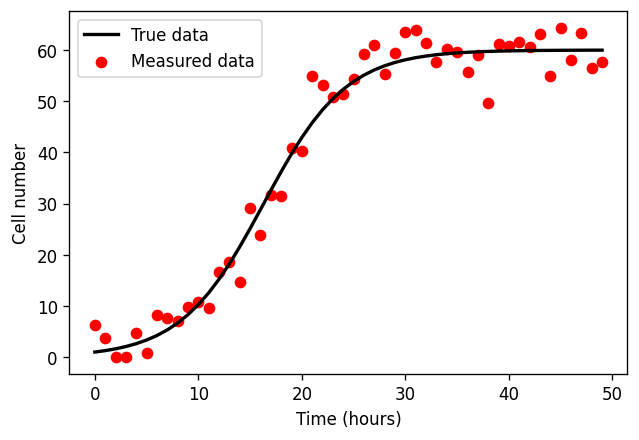

In [5]:
# Plotting the true and observed data
fig, ax = plt.subplots(dpi=120)
plt.plot(times, y, label='True data', color='black',linewidth=2.0)
plt.scatter(times, yobs, label='Measured data', color='red')
plt.legend()
plt.xlabel('Time (hours)')
plt.ylabel('Cell number');
#plt.savefig("just_data.pdf")
plt.show()

## Maximum likelihood estimation

Find $\hat{\boldsymbol{\theta}}\in\Theta$, where $\Theta$ is the parameter space, that maximize the likelihood.\bigskip

It is customary to work with the more manageable log-likelihood function.

\begin{align*}
\hat{\boldsymbol{\theta}}&=\underset{\boldsymbol{\theta}\in\Theta}{\text{argmax}}[\log\pi(\boldsymbol{D}|\boldsymbol{\theta})];\\
&=\underset{\boldsymbol{\theta}\in\Theta}{\text{argmax}}\left[-\frac{N_t}{2}\log(2\pi)-\frac{N_t}{2}\log(\sigma^2)-\sum_{i=1}^{N_t}\frac{1}{2}\frac{(D_{i}-Y_i(\boldsymbol{\theta}))^2}{2\sigma^2}\right].
\end{align*}

In [6]:
def log_likelihood(theta, times, y):
    cal_growth, cal_carry, cal_std = theta
    model = odeint(control_tumor, t=times, y0=y[0], args=tuple([[cal_growth,cal_carry]]))
    variance = cal_std*cal_std
    return -0.5 * np.sum((y - model) ** 2 / variance + np.log(2*np.pi) + np.log(variance))

In [81]:
nll = lambda *args: -log_likelihood(*args)
initial = np.array([0.4, 50.0, 0.3])+ 0.1 * np.random.randn(3)
bounds = Bounds([0.0, 10.0, 0.1], [1.0, 120.0, 50.0])
soln = minimize(nll, initial, args=(times, yobs), bounds=bounds)
ml_growth, ml_carry, ml_std = soln.x

print("Maximum likelihood estimates:")
print("Growth rate = %f" % ml_growth)
print("Carrying capacity = %f" % ml_carry)
print("Standard deviation = %f" % ml_std)

error_g=100*abs(ml_growth-true_growth)/true_growth
error_k=100*abs(ml_carry-true_carry)/true_carry
error_s=100*abs(ml_std-true_std)/true_std

print("Growth rate %% error = %f" % error_g)
print("Carrying capacity %% error = %f" % error_k)
print("Standard deviation %% error = %f" % error_s)

Maximum likelihood estimates:
Growth rate = 0.138937
Carrying capacity = 63.533486
Standard deviation = 6.289305
Growth rate % error = 44.425181
Carrying capacity % error = 5.889143
Standard deviation % error = 74.702915


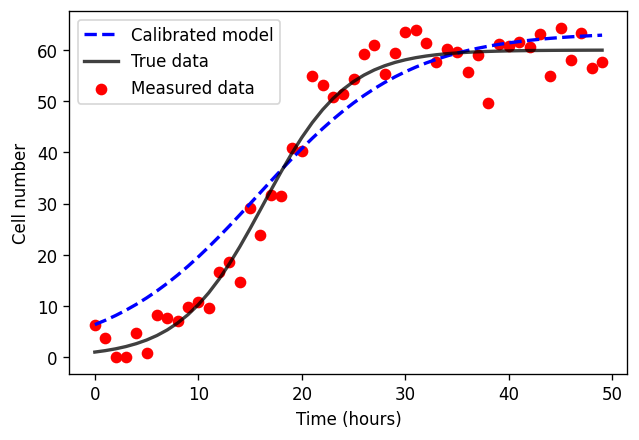

In [8]:
y_ml = odeint(control_tumor, t=times, y0=yobs[0], args=tuple([[ml_growth,ml_carry]]))
fig, ax = plt.subplots(dpi=120)
plt.plot(times, y_ml, label='Calibrated model', linestyle='dashed', color='blue',linewidth=2.0)
plt.plot(times, y, label='True data', color='black', alpha=0.75,linewidth=2.0)
plt.scatter(times, yobs, label='Measured data', color='red')
plt.legend()
plt.xlabel('Time (hours)')
plt.ylabel('Cell number');
#plt.savefig("ml_fit.pdf")
plt.show()

In [9]:
def log_likelihood_ic(theta, times, y):
    cal_growth, cal_carry, cal_std, cal_ic = theta
    model = odeint(control_tumor, t=times, y0=cal_ic, args=tuple([[cal_growth,cal_carry]]))
    variance = cal_std*cal_std
    return -0.5 * np.sum((y - model) ** 2 / variance + np.log(2*np.pi) + np.log(variance))

In [80]:
nll = lambda *args: -log_likelihood_ic(*args)
initial = np.array([0.4, 50.0, 0.3, 5.0])+ 0.1 * np.random.randn(4)
bounds = Bounds([0.0, 10.0, 0.1, 0.1], [1.0, 120.0, 50.0, 20.0])
soln = minimize(nll, initial, args=(times, yobs), bounds=bounds)
ml_growth, ml_carry, ml_std, ml_ic = soln.x

print("Maximum likelihood estimates:")
print("Growth rate = %f" % ml_growth)
print("Carrying capacity = %f" % ml_carry)
print("Standard deviation = %f" % ml_std)
print("Initial condition = %f" % ml_ic)

error_g=100*abs(ml_growth-true_growth)/true_growth
error_k=100*abs(ml_carry-true_carry)/true_carry
error_s=100*abs(ml_std-true_std)/true_std
error_i=100*abs(ml_ic-true_ic)/true_ic

print("Growth rate %% error = %f" % error_g)
print("Carrying capacity %% error = %f" % error_k)
print("Standard deviation %% error = %f" % error_s)
print("Initial condition %% error = %f" % error_i)

Maximum likelihood estimates:
Growth rate = 0.268103
Carrying capacity = 60.229667
Standard deviation = 3.525997
Initial condition = 0.741896
Growth rate % error = 7.241228
Carrying capacity % error = 0.382778
Standard deviation % error = 2.055644
Initial condition % error = 25.810369


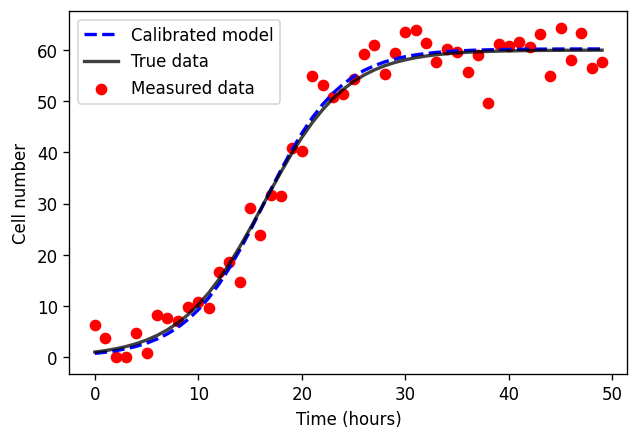

In [11]:
y_ml = odeint(control_tumor, t=times, y0=ml_ic, args=tuple([[ml_growth,ml_carry]]))
fig, ax = plt.subplots(dpi=120)
plt.plot(times, y_ml, label='Calibrated model', linestyle='dashed', color='blue',linewidth=2.0)
plt.plot(times, y, label='True data', color='black', alpha=0.75,linewidth=2.0)
plt.scatter(times, yobs, label='Measured data', color='red')
plt.legend()
plt.xlabel('Time (hours)')
plt.ylabel('Cell number');
#plt.savefig("ml_fit.pdf")
plt.show()

## Bayesian approach
Given events A and B:
\begin{align*}
P(A,B)&=P(A|B)P(B);\\
P(A,B)&=P(B,A);\\
P(B,A)&=P(B|A)P(A);\\
P(A|B)P(B)&=P(B|A)P(A);\\
P(A|B)&=\frac{P(B|A)P(A)}{P(B)};
\end{align*}

Converting to probability densities $\pi$, if $A$ represents the parameter $\boldsymbol{\theta}$ of a model, and $B$ the observational data $\boldsymbol{D}$:
\begin{align*}
\underbrace{\pi(\boldsymbol{\theta}|\boldsymbol{D})}_{\text{posterior}}&=\frac{\overbrace{\pi(\boldsymbol{D}|\boldsymbol{\theta})}^{\text{likelihood}}\overbrace{\pi(\boldsymbol{\theta})}^{\text{prior}}}{\underbrace{\pi(\boldsymbol{D})}_{\text{evidence}}};\qquad \pi(\boldsymbol{D})=\int_\Theta\pi(\boldsymbol{D}|\boldsymbol{\theta})\pi(\boldsymbol{\theta})\, \text{d}\theta\\
\pi(\boldsymbol{\theta}|\boldsymbol{D})&\propto\pi(\boldsymbol{D}|\boldsymbol{\theta})\pi(\boldsymbol{\theta});\\
\log\pi(\boldsymbol{\theta}|\boldsymbol{D})&\propto\log\pi(\boldsymbol{D}|\boldsymbol{\theta})+\log\pi(\boldsymbol{\theta});
\end{align*}

In [12]:
def log_prior(theta):
    cal_growth, cal_carry, cal_std, cal_ic = theta
    if 0.0 < cal_growth < 1.0 and 10.0 < cal_carry < 120.0 and 0.1 < cal_std < 50.0 and 0.1 < cal_ic < 20.0:
        return 0.0
    return -np.inf

In [13]:
def log_probability(theta, times, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_ic(theta, times, y)

In [14]:
mean_g = np.array([0.4, 50.0, 0.3, 10.0])
pos = mean_g + 1e-2 * np.random.randn(10,4)

In [15]:
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(times, yobs))
sampler.run_mcmc(pos, 12500, progress=True);

100%|██████████| 12500/12500 [00:51<00:00, 244.73it/s]


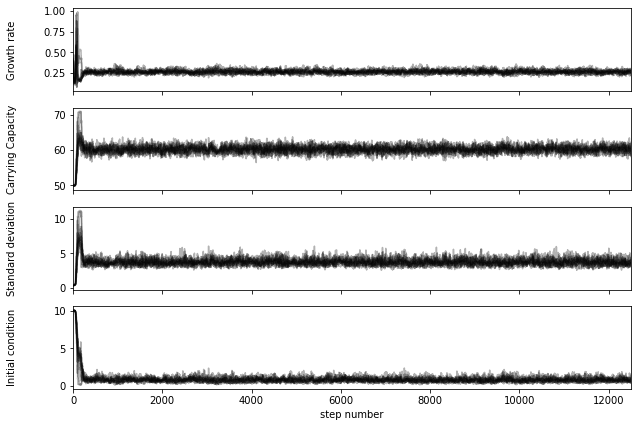

In [16]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Growth rate", "Carrying Capacity", "Standard deviation", "Initial condition"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [17]:
tau = sampler.get_autocorr_time()
print(tau)

[ 71.55158338  43.16679644  40.56768278 150.95704435]


In [18]:
flat_samples = sampler.get_chain(discard=450, flat=True)
print(flat_samples.shape)

(120500, 4)


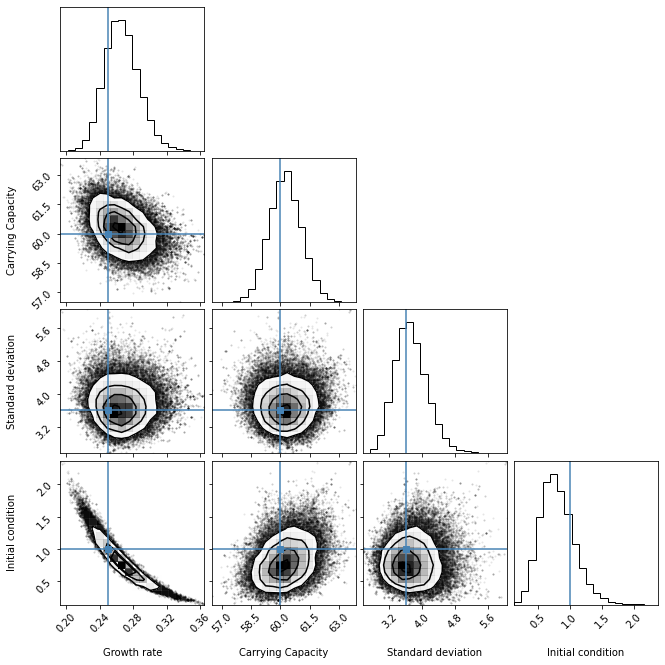

In [19]:
fig = corner.corner(flat_samples, labels=labels, truths=[true_growth, true_carry, true_std, true_ic]);

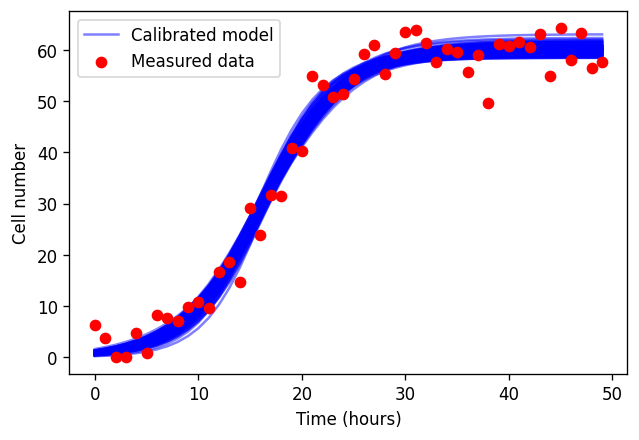

In [23]:
fig, ax = plt.subplots(dpi=120)
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    y_sp = odeint(control_tumor, t=times, y0=sample[3], args=tuple([[sample[0],sample[1]]]))
    plt.plot(times, y_sp, 'blue', alpha=0.5)
plt.plot(times, y_sp, label='Calibrated model', color='blue', alpha=0.5)
plt.scatter(times, yobs, zorder=100, label='Measured data', color='red')
plt.legend()
plt.xlabel('Time (hours)')
plt.ylabel('Cell number');
#plt.savefig("bc_fit.pdf")
plt.show()

In [21]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>